# Loan default prediction

The dataset comes from [this kaggle competition](https://www.kaggle.com/c/credit-default-prediction-ai-big-data/overview)

Our approach:
* Standard imports
* Read in data and look at summary statistics
* EDA (distributions, relationships)
* Model selection, model building (may try a few)
* Answer the 'so what'

## Data cleaning notebook - to be converted to .py script later

**Cleaning tasks:**
* To drop:
    * accounts with loan balance of 100,000,000
    * 'Leaky' variables: drop credit score, ID
* Deal with missing values
    * Income - median
    * Years in current job - median
    * Months since last delinquency - might be able to assume these are people without previous delinquencies, which means we may be able to put in a very high value (e.g. 999) and create a related dummy variable
    * Bankruptcies - if null then assume no bankruptcies
    * (credit score missing values don't matter because we will drop this anyway)
* Extract number from years in current job
* Make dummy variables out of categorical vairables
    * 'purpose' seems like a free text field - may make a dummy variable for is/isn't debt consolidation
    * Home ownership - 'have mortgage' can grouped with home mortgage
    * Term - 'short/long term' flag
* Deal with imbalanced dataset

**Note:** Currently not doing any fancy feature engineering - could add later if required

**Improvement: functions to drop unused columns as separate function to be applied at the end so that we can remove steps with a bit more flexibility**

In [1]:
# standard imports
from typing import List
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame # for type hints
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

### SHOULD REALLY ADD SOME UNIT TESTS HERE
### ALSO NEED TO ADD TEST TO CHECK IF NEEDED, OTHERWISE PASS (I.E. IF FUNCTION HAS ALREADY BEEN RUN)

# drop accounts with large loan balance
def drop_large_loans(df: DataFrame) -> DataFrame:
    """
    Drop rows with loan balance of 99,999,999
    """
    df = df[df["Current Loan Amount"] != 99999999].copy()
    
    return df


# Years in current job -> numeric
def convert_job_year_col(df: DataFrame) -> DataFrame:
    """
    Convert years in current job column to numeric by extract numbers
    """
    # first need to manually map <1 year to zero so extracting numbers doesn't equate them
    df.loc[df["Years in current job"].str.strip() == "< 1 year", "Years in current job"] = 0

    # extract number from string
    df["Years in current job"] = (
        df["Years in current job"]
        .str.extract("(\d+)", expand=False)
        .astype("float64", errors="ignore") # match one or more digits
    )
    
    return df


# deal with months since last delinquency
def impute_months_since_last_delinquent_col(df: DataFrame,
                                            impute_value: int = 150) -> DataFrame:
    """
    Fill null values in 'Months since last delinquent' column
    with high value: e.g. 10. Cannot impute with 0 because a lower number would generally suggest 
    a recent delinquency. This is based on the assumption that the null values in this column
    mean a customer has not previously been delinquent.
    
    However, it might be better to just drop this column
    """
    df["Months since last delinquent"].fillna(impute_value, inplace=True)
    
    return df


# impute zero for records without bankruptcy
def impute_bankruptcy_col(df: DataFrame,
                          impute_value: int = 0) -> DataFrame:
    """
    Assuming that a null value for bankruptcy indicates no previous bankruptcies
    """
    df["Bankruptcies"].fillna(impute_value, inplace=True)
    
    return df


# impute median for relevant columns (income, years in current job)
def impute_median(df: DataFrame,
                  cols_to_fill: List[str] = ["Annual Income", "Years in current job"]) -> DataFrame:
    """
    Fills the specified columns with the median of the column
    """
    # TO ADD: unit to test to check year in current job in numeric
    # this checks that previous function has been applied
    assert df["Years in current job"].dtype == "float64"
    
    for col in cols_to_fill:
        df[col].fillna((df[col].median()), inplace=True)
    
    # check columns have no nulls
    for col in cols_to_fill:
        assert df[col].isnull().sum() == 0, f"Still null values in column: {col}!"
    
    return df


# Make flag out of "purpose" column
def convert_purpose_col(df: DataFrame) -> DataFrame:
    """
    The Purpose column is a free text field with debt consolidation
    having a much higher proportion of records than any other value.
    This will convert the Purpose column into a flag for debt consolidation
    (This could be done dynamically but because this isn't a live dataset we'll
    just hardcode the given column)
    """
    df["debt_consolidation_purpose_flag"] = (df["Purpose"] == "debt consolidation")
        
    # Just to check numbers are the same (don't want to manually check as the pipeline drops some rows)
    assert df["debt_consolidation_purpose_flag"].sum() == (df["Purpose"] == "debt consolidation").sum()
    
    return df

# Convert home ownership UNUSED
def convert_home_ownership_col(df: DataFrame) -> DataFrame:
    """
    UNUSED - have function for converting multiple
    First convert 'Have mortgage' value into 'Home Mortgage'
    because number is so small. Then create a dummy variable from them
    """
    df.loc[df["Home Ownership"] == "Have Mortgage", "Home Ownership"] = "Home Mortgage"
    
    dummy_cols = pd.get_dummies(df["Home Ownership"], drop_first=True)
    
    df = pd.concat([df, dummy_cols], axis=1)
    
#     df.drop("Home Ownership", axis=1, inplace=True)
    
    return df


# Convert categorical columns into dummy variables
def convert_categorical_cols(df: DataFrame,
                             cols: List[str] = ["Home Ownership", "Term"]) -> DataFrame:
    """
    TBU
    First convert 'Have mortgage' value into 'Home Mortgage'
    because number is so small. Then create a dummy variable from them
    """
    for col in cols:
        if col == "Home Ownership": # if home ownership we need to reassign some values
            df.loc[df["Home Ownership"] == "Have Mortgage", "Home Ownership"] = "Home Mortgage"
        else:
            pass
        
        # convert categorical columns into dummy variable (gives separate dataframe)
        dummy_cols = pd.get_dummies(df[col], drop_first=True)
    
        # add dummy columns to dataframe
        df = pd.concat([df, dummy_cols], axis=1)

        # drop old columns
#         df.drop(col, axis=1, inplace=True)
    
    return df

# drop unused colums

def drop_cols(df: DataFrame,
              drop_cols: List[str] = ["Id", "Credit Score", "Purpose", "Home Ownership", "Term"],
              extra_drop_cols: List[str] = []) -> DataFrame:
    """
    Drop the columns specified; (default was ID and credit score but these
    can be specified manually if required)
    
    Here we also drop columns manipulated in the other functions because 
    regardless of whether or not we 'add' in the altered version, we want
    to drop the 'unclean' version
    
    extra_drop_cols is just an easy way to append columns without changing the default list
    """
    if extra_drop_cols:
        drop_cols.extend(extra_drop_cols)
    
    df.drop(drop_cols, axis=1, inplace=True)
    
    return df

# Imbalanced target class - probably deal with later (in CV stage)



In [2]:
# read in data
df = pd.read_csv("data/train.csv")

In [3]:
# pipe cleaning functions together
df_clean = (
    df
    .pipe(drop_large_loans)
    .pipe(convert_job_year_col)
    .pipe(impute_months_since_last_delinquent_col)
    .pipe(impute_bankruptcy_col)
    .pipe(impute_median)
    .pipe(convert_purpose_col)
    .pipe(convert_categorical_cols)
    .pipe(drop_cols, extra_drop_cols=["Number of Credit Problems", "Monthly Debt"])
)

# Check all columns have no null
assert [df_clean[col].isnull().sum() == 0 for col in df_clean.columns]

In [4]:
# If the above functions run correctly and the unit tests pass 
# we can pickle the dataframe to pick up in another script
df_clean.to_pickle("./data_cleaned.pkl")

### Let's just now quickly check the correlations

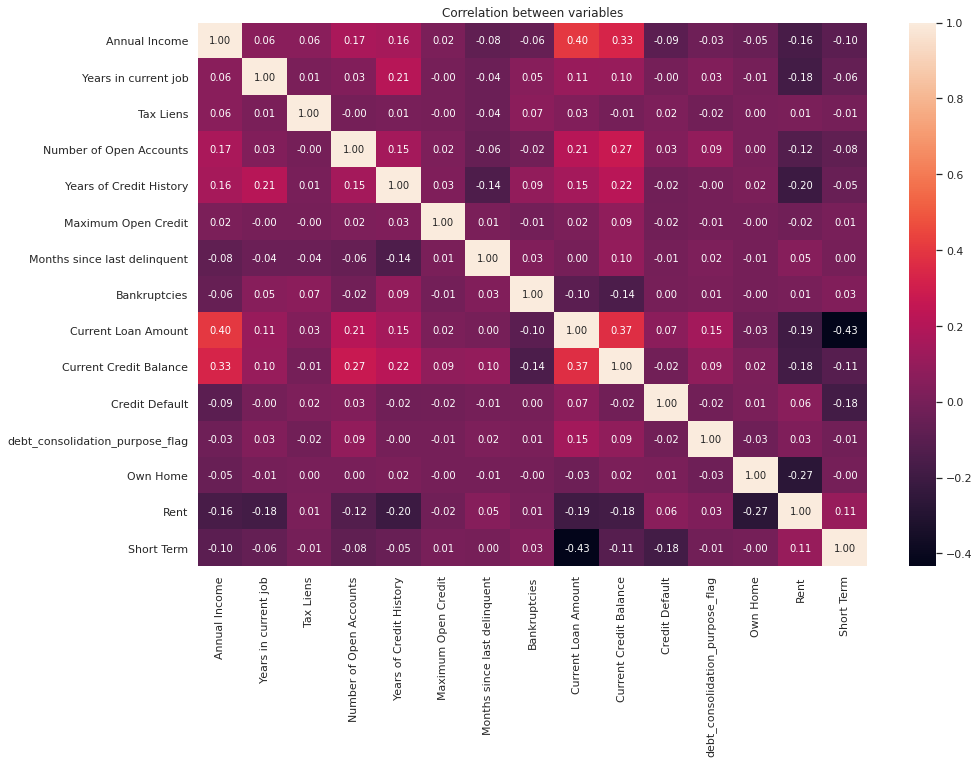

In [5]:
# correlations
f, ax = plt.subplots(1, 1, figsize=(15,10))

correlations = df_clean.corr()
sns.heatmap(correlations, annot=True, fmt=".2f", ax=ax)

ax.set_title("Correlation between variables")

plt.show()